# Baseline Comparisson

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

In [2]:
path_res = f'../activation-prediction/results/ergo2_vdjdb.csv'
prediction_ergo = pd.read_csv(path_res, index_col=0)
prediction_ergo = prediction_ergo[prediction_ergo['Peptide']!='SIINFEKL']

In [3]:
path_our = '../activation-prediction/results/tcr_stratified_classification_performance.csv.gz'
prediction_ours = pd.read_csv(path_our, compression='gzip')
prediction_ours = prediction_ours[prediction_ours['normalization']=='AS']
prediction_ours = prediction_ours[prediction_ours['threshold']==46.9]
prediction_ours = prediction_ours[prediction_ours['tcr'].isin(prediction_ergo['tcr'].unique())]

In [4]:
def get_auc_per_tcr(data, tcr, y_true, ergo=True):
    data_tmp = data[data['tcr']==tcr]
    col_pred = 'pred'
    if ergo:
        col_pred = 'Score'
    y_pred = data_tmp[col_pred]
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    return auc_score  

In [5]:
performance = []

for tcr in prediction_ergo['tcr'].unique():
    y_true = prediction_ours[prediction_ours['tcr']==tcr]['is_activated']
    auc_ergo = get_auc_per_tcr(prediction_ergo, tcr, y_true)
    auc_ours = get_auc_per_tcr(prediction_ours, tcr, y_true, ergo=False)
    performance.append([tcr, auc_ergo, auc_ours])
performance = pd.DataFrame(performance, columns=['tcr', 'ergo', 'ours'])
performance = performance[~performance['tcr'].isin(['LR_OTI_1', 'LR_OTI_2'])]
performance = performance.set_index('tcr')

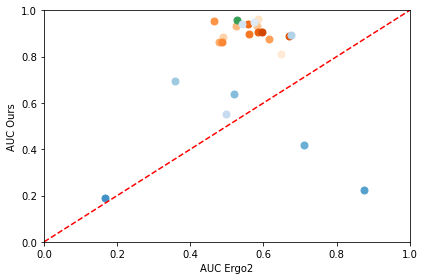

In [6]:
educated_colors = sns.color_palette(
    'Oranges', n_colors=16 + 4
)
educated_idx = 1

naive_colors = sns.color_palette(
    'Blues', n_colors=11 + 4
)
naive_idx = 1

ot1_colors = sns.color_palette(
    'Greens', n_colors=2
)
ot1_idx = 1

for row in performance.iterrows():
    if row[0] == 'OTI_PH':
        c = ot1_colors[ot1_idx]
        ot1_idx += 1
    elif row[0].startswith('ED'):
        c = educated_colors[educated_idx]
        educated_idx += 1
    else:
        c = naive_colors[naive_idx]
        naive_idx += 1
    plt.plot(row[1]['ergo'], row[1]['ours'], c=c, marker='o', markersize=7)

plt.xlabel('AUC Ergo2')
plt.ylabel('AUC Ours')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.plot((0, 1), (0, 1), 'r--')

#plt.show()
plt.tight_layout()
plt.savefig('../activation-prediction/figures/ergo2_comparission.pdf')

# Active Learning within TCR

In [7]:
import json
import os

In [8]:
N = 8
M = 10

In [9]:
def correlation(method):
    def corr_method(y_true, y_pred):
        df = pd.DataFrame()
        df['y_true'] = y_true
        df['y_pred'] = y_pred
        corr = df['y_true'].corr(df['y_pred'], method=method)
        return corr
    return corr_method

metrics_cls = [
    {
        'auc': metrics.roc_auc_score,
        'aps': metrics.average_precision_score,
    },
    {
        'F1': metrics.f1_score,
        'Accuracy': metrics.accuracy_score,
        'Precision': metrics.precision_score,
        'Recall': metrics.recall_score,
    }
]


metrics_reg = {
    'MAE': metrics.mean_absolute_error,
    'R2': metrics.r2_score,
    'Pearson': correlation(method='pearson'),
    'Spearman': correlation(method='spearman'),
}

In [10]:
path_out = f'../activation-prediction/results/al/TEST_act_avg_8.json'
with open(path_out) as f:
    results_act_avg = json.load(f)

In [11]:
path_out = f'../activation-prediction/results/al/TEST_rdm_8.json'
with open(path_out) as f:
    results_rdm = json.load(f) 

In [12]:
def read_greedy_bound(n):
    path_in = f'../activation-prediction/results/al/test_set_within_{n}/'
    res_files = [path_in + f for f in os.listdir(path_in) if os.path.isfile(os.path.join(path_in, f))]

    results_upper = {}
    for name in list(metrics_reg.keys()) + list(metrics_cls[0].keys()) + list(metrics_cls[1].keys()):
        results_upper[name] = []

    for path_file in res_files:
        with open(path_file) as f:
            res_tmp = json.load(f)
        for mtc, vals in res_tmp.items():
            results_upper[mtc] += vals
    return results_upper
results_upper = read_greedy_bound(8)

In [13]:
summary_8 = {
    'active_avg': results_act_avg,
    'random': results_rdm,
    'upper bound': results_upper,
}

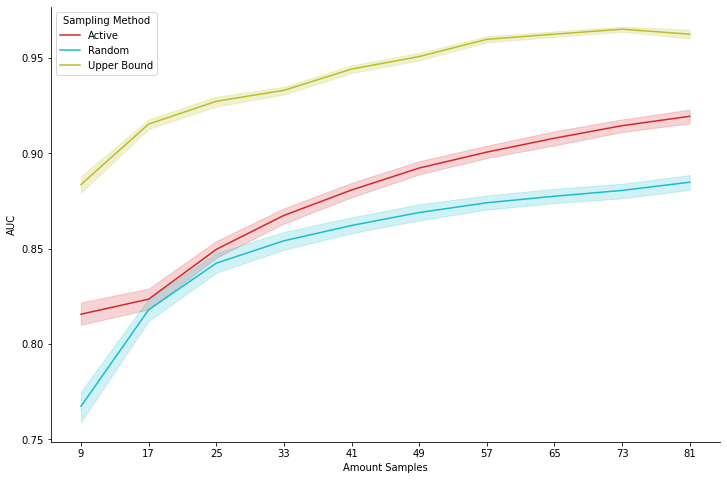

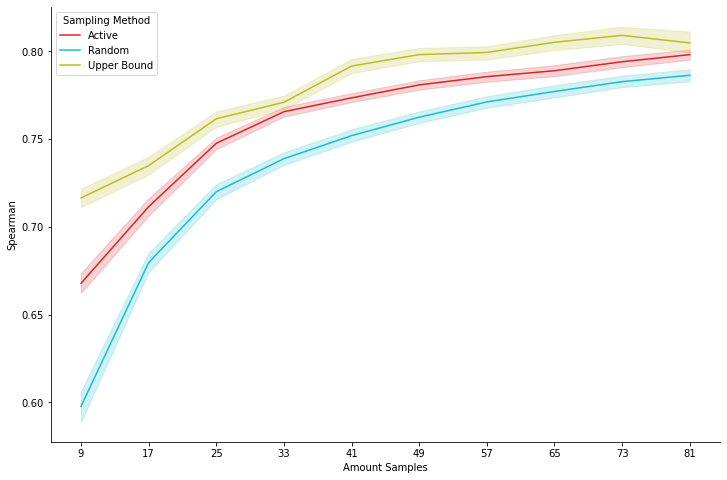

In [14]:
palette = {'active_avg': 'tab:red', 'upper bound': 'tab:olive', 'random': 'tab:cyan'}

for name in ['auc', 'Spearman']:
    plt.figure(figsize=(12, 8))
    dfs_results = []
    for method in summary_8.keys():
        df = pd.DataFrame(summary_8[method][name])
        df.columns = ['tcr', 'is_educated', 'iteration', name]
        df['method'] = method
        dfs_results.append(df)
    df_joint = pd.concat(dfs_results)
    plot = sns.lineplot(data=df_joint, x='iteration', y=name, hue='method', palette=palette)
    sns.despine(bottom=False, left=False)
    
    plot.set(xlabel='Amount Samples')
    if len(name)<=3:
        plot.set(ylabel=name.upper())
        
    plt.legend(title='Sampling Method', labels=['Active', 'Random', 'Upper Bound'])
    x_ticks = list(range(0, M))
    x_labels = ['9'] + [str(9+(i+1)*N) for i in range(M-1)]
    plot.set_xticks(x_ticks)
    plot.set_xticklabels(x_labels)
    plot.figure.savefig(f'../activation-prediction/figures/active_learning/active_within_class_{name}.png', dpi=360)
    plot.figure.savefig(f'../activation-prediction/figures/active_learning/active_within_class_{name}.pdf', dpi=360)
    plt.show()

# Heatmap

In [4]:
data_naive = pd.read_csv('../data/activations_lena.csv', index_col=0)
data_naive = data_naive.drop(['OT1'], axis=1)
#data_naive = data_naive[['OT1', 'B11', 'B15']]
data_educated = distance_matrix = pd.read_csv('../data/activations_phillip.csv', index_col=0)
data_joint =  pd.concat([data_naive, data_educated], axis=1, join='inner')

order = list(data_joint.columns)
order.remove('OT1')
order = ['OT1'] + order
data_joint = data_joint[order]

In [18]:
def read_normalized_data(is_educated, normalization='AS'):
    if is_educated:
        path_in = '../data/PH_data_educated_repertoire_and_OTI.xlsx'
    else:
        path_in = '../data/LR_data_naive_repertoire_and_OTI.xlsx'
    if normalization == 'AS':
        df = pd.read_excel(path_in, 'Normalized to initial AS')
    else:
        df = pd.read_excel(path_in, 'Unnormalized Data')
    columns = df.columns
    tcrs = columns[::4]
    columns = columns[3::4]
    df = df[columns]
    df.columns = tcrs
    return df

data_naive = read_normalized_data(False)
data_naive = data_naive.drop(['LR_OTI_1', 'LR_OTI_2'], axis=1)
data_educated = read_normalized_data(True)
data_joint =  pd.concat([data_naive, data_educated], axis=1, join='inner')
order = list(data_joint.columns)
order.remove('OTI_PH')
order = ['OTI_PH'] + order
data_joint = data_joint[order]

In [11]:
print(f'All TCRs: {len(data_joint.columns)}')
print(f'Naive TCRs: {len(data_naive.columns)}')
print(f'Educated TCRs: {len(data_educated.columns)-1}')
print(f'OTI TCRs: 1')

All TCRs: 36
Naive TCRs: 20
Educated TCRs: 15
OTI TCRs: 1


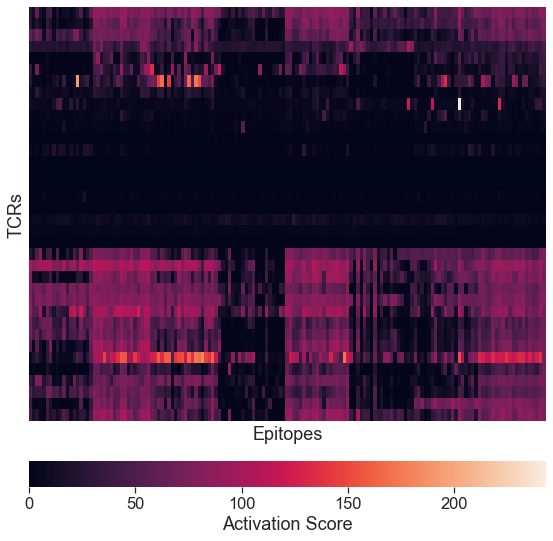

In [17]:
def plot_heatmap(data_tmp):
    data = data_tmp.transpose()
    sns.set(font_scale=1.5)
    sns.set_style('white')
    plt.figure(figsize=(8, 8))
   
    plot = sns.heatmap(data,
                       cbar_kws={"orientation": "horizontal", 'label': 'Activation Score', 'pad': 0.075})#, cbar_pos=(0.19, 0, 0.66, .05)) #)
    # left bottom width height
  
    # ax = plot.ax_heatmap
    # ax = plot
    plot.set_yticks([])
    plot.set_xticks([])
    
    plot.set(xlabel='Epitopes', ylabel='TCRs')
    plot.yaxis.set_label_position("left")
    plot.figure.savefig(f'../figures/histogram.png', dpi=360)
    plot.figure.savefig(f'../figures/histogram.pdf', dpi=360)
    plt.tight_layout()
    plt.show()
plot_heatmap(data_joint)

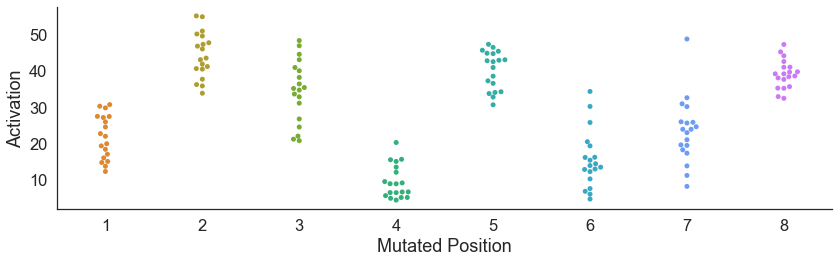

In [31]:
def plot_positions(data_tmp, kind='swarm'):
    data = data_tmp.copy()
    data['Activation'] = np.mean(data.values, axis=1)
    data = data[['Activation']]
    data['Mutated Position'] = [f'{int(i/19)+1}' for i in range(0, 152)] + ['-']
    data = data.reindex(['SIINFEKL'] + data.index[0:-1].values.tolist())
    
    sns.set(font_scale=1.5)
    sns.set_style('white')
    plt.figure(figsize=(12, 4))
    order = ['-'] + [str(i) for i in range(1, 9)]
    
    palette = sns.color_palette('husl', n_colors=10)[1:]
    plot = sns.swarmplot(data=data, y='Activation', x='Mutated Position',
                       hue='Mutated Position', palette=palette, dodge=False)
    plot.get_legend().remove()
    sns.despine()
    plt.tight_layout()
    plt.show()
    
plot_positions(data_joint, kind='swarm')

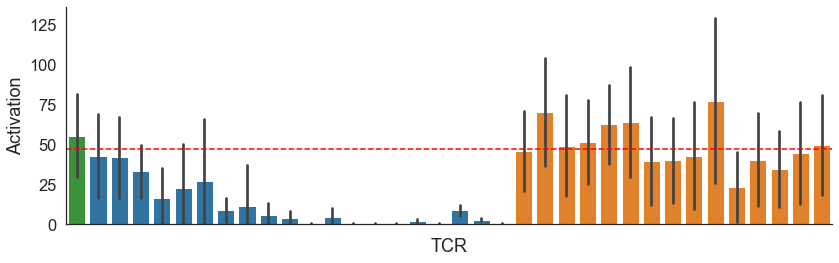

In [24]:
def plot_tcrs(data_tmp, threshold=46.9, suffix=''):
    data = []
    for col in data_tmp.columns:
        for row in data_tmp.index:
            val = data_tmp.loc[row, col]
            data.append([col, row, val])
    data = pd.DataFrame(data, columns=['TCR', 'Epitope', 'Activation'])
    data['cat'] = 'Naive'
    data.loc[data['TCR'] == 'OTI_PH', 'cat'] = 'OT1'
    data.loc[data['TCR'].str.startswith('Ed'), 'cat'] = 'Educated'

    sns.set(font_scale=1.5)
    sns.set_style('white')
    plt.figure(figsize=(12, 4))
    
    palette = {'OT1': 'tab:green', 'Naive': 'tab:blue', 'Educated': 'tab:orange'}
    plot = sns.barplot(data=data, y='Activation', x='TCR', hue='cat', palette=palette, dodge=False, ci='sd')
    if threshold is not None:
        plot.axhline(46.9, color='red', linestyle='--')
    
    plt.ylim(bottom=0)
    plot.set_xticklabels([])
    plot.get_legend().remove()
    sns.despine()
    plt.tight_layout()
    plot.figure.savefig(f'../figures/data_by_tcr_{suffix}.png', dpi=360)
    plot.figure.savefig(f'../figures/data_by_tcr_{suffix}.pdf', dpi=360)
    plt.show()
    
plot_tcrs(data_joint, suffix='norm')   

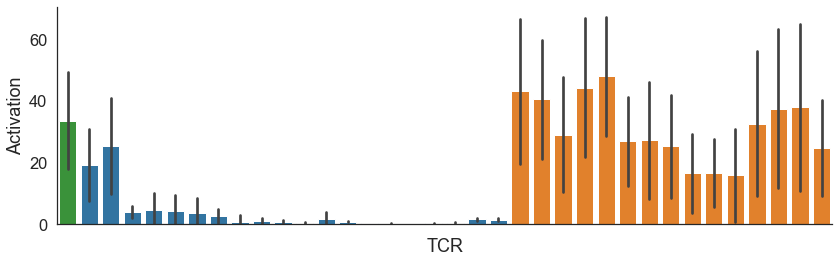

In [25]:
data_naive = read_normalized_data(False, normalization='None')
data_naive = data_naive.drop(['LR_OTI_1', 'LR_OTI_2'], axis=1)
data_educated = read_normalized_data(True, normalization='None')
data_joint_unnormalized =  pd.concat([data_naive, data_educated], axis=1, join='inner')
order = list(data_joint_unnormalized.columns)
order.remove('OTI_PH')
order = ['OTI_PH'] + order
data_joint_unnormalized = data_joint_unnormalized[order]
data_joint_unnormalized

plot_tcrs(data_joint_unnormalized, threshold=None, suffix='unnorm')

## 3D Model

In [14]:
fname = '../manuscript/results/distances_SIINFEKL.csv'
distances = pd.read_csv(fname, index_col=0)
distances

,features_alpha,features_beta
B10,"22.37471280620683,19.605202188139476,16.752810...","30.065579525742255,26.798206138904693,25.60129..."
B11,"22.66134290589852,19.963202212662306,16.810194...","29.556694650946824,26.230716868216643,25.29436..."
B13,"23.055718694541863,20.266017261300053,16.07493...","29.98517019591422,26.756179346368597,25.697666..."
B14,"23.323002309876163,20.10385754014805,16.804973...","30.22697262484288,26.649404452094572,26.002235..."
B15,"22.983889447017983,20.40675512122189,17.410218...","30.494359131199886,26.670454940293773,25.33920..."
B16,"22.616799816806076,19.88439629457214,16.778905...","30.34227105116839,26.50288482297526,25.2764315..."
B2,"23.118207324145406,20.272419301522643,16.89001...","29.91117132868836,26.509298851533337,25.230014..."
B3,"22.950290669055747,20.13934087734178,17.072604...","30.039584157652765,26.16936723024881,24.476285..."
B5,"23.683435550366575,19.960150342233767,16.86325...","29.438732710824148,26.083314485402404,24.91067..."
B6,"22.4983517266664,19.838946743060294,16.1225068...","30.048897289580633,26.19565953021741,25.047530..."


In [29]:
def get_distance_matrices(do_alpha=True):
    col = 'features_beta'
    if do_alpha:
        col = 'features_alpha'
    col = distances[col]
    
    distance_dict = {}
    for tcr in col.index:
        dist = col[tcr]
        dist = dist.split(',')
        dist = [float(el) for el in dist]
        dist = np.array(dist)
        dist = dist.reshape(8,-1)
        distance_dict[tcr] = dist
    return distance_dict
distances_alpha = get_distance_matrices()
distances_beta = get_distance_matrices(do_alpha=False)

In [32]:
distances_beta['OT1']

array([[29.72688503, 25.85170581, 24.59364065, 21.12465835, 22.38320848,
        17.56993661, 18.16294154, 16.26778974, 21.35314769, 22.48804875,
        25.54729277, 27.59078076],
       [27.68546381, 23.81822728, 22.27246452, 18.72879371, 20.0157384 ,
        14.92900986, 16.50385459, 14.83065266, 20.00749761, 20.99344   ,
        23.75896999, 26.25574496],
       [24.83975362, 20.88999938, 18.89917833, 15.31573977, 16.00797837,
        10.83203859, 12.51659994, 11.68991827, 16.31429637, 17.8365636 ,
        20.09815787, 23.20756192],
       [21.45966268, 17.57720513, 16.09866516, 12.59365479, 14.56197244,
         9.97859186, 11.58245247,  8.94636896, 14.48012768, 14.89864696,
        17.82053625, 20.14220894],
       [23.04379479, 19.29438066, 17.19428981, 13.74478411, 14.86678858,
         9.86538966, 12.90680029, 11.94903997, 16.47306328, 17.29661888,
        19.28019649, 22.5165863 ],
       [18.04779763, 14.32153981, 11.68466526,  8.33776531,  9.21744702,
         4.88424248,  

In [55]:
max_value = 0
min_value = 99
min_dist_dict = {}
for tcr in distances_beta:
    dist_alpha = distances_alpha[tcr]
    dist_alpha = np.min(dist_alpha, axis=1)
    
    dist_beta = distances_beta[tcr]
    dist_beta = np.min(dist_beta, axis=1)

    dist_total = np.stack([dist_alpha, dist_beta])
    dist_total = np.min(dist_total, axis=0, keepdims=True)
    min_dist_dict[tcr] = dist_total
    max_value = max(np.max(dist_total).tolist(), max_value)
    min_value = min(np.min(dist_total).tolist(), min_value)
print(max_value)
print(min_value)

12.503406009016254
3.40788939628884


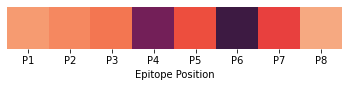

In [66]:
dist = min_dist_dict['OT1']
x_labels = [f'P{i+1}' for i in range(8)]
plot = sns.heatmap(dist, square=True, vmin=min_value, vmax=max_value, xticklabels=x_labels, cbar=False)
#cbar_kws={"orientation": "horizontal", 'label': 'Activation Score', 'pad': 0.075})

plot.set_yticks([])
#plot.set_xticks([])

plot.set(xlabel='Epitope Position')

In [105]:
import matplotlib as mpl

AttributeError: 'Colorbar' object has no attribute 'set_ticks_position'

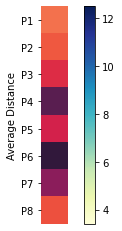

In [122]:
dist = min_dist_dict
dist = np.stack(dist.values())
dist = dist.reshape(-1, 8)
dist = np.mean(dist, keepdims=True, axis=0)
dist = dist.T

y_labels = [f'P{i+1}' for i in range(8)]
plot = sns.heatmap(dist, square=True, vmin=min_value, vmax=max_value, yticklabels=y_labels,
                   cbar=False,
                  cbar_kws={'label': 'Distance in Å', 'location': 'left', 'use_gridspec': False, 'pad': 0.15})
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0)
plot.set_ylabel('Average Distance')
plot.set_xticks([])

norm = mpl.colors.Normalize(min_value, max_value)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap='YlGnBu'))
cb.set_ticks_position('left')